# Solution 1

## FINM 37400 - 2023

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

This homework relies on the data file, `treasury_quotes_2022-09-30`.

The problems below analyze the nominal, (rather than the TIPS,) Treasury issues. Accordingly, you should filter out all rows with `ITYPE` of 11 or 12, as these indicate a TIPS Note or TIPS bond.

#### #Update as of Jan 7 at 3pm*

Find more info about many of the fields in the data set at the following link,

https://www.crsp.org/products/documentation/treasno-properties

Find the complete manual for the CRSP Treasury data at the following link,

https://www.crsp.org/files/treasury_guide_0.pdf

# Problem 1: Explore the Data

## 1 Maturity

For each issue, calculate its time-to-maturity, quoted in number of years, based on the issue and maturity dates. Assume a year has exactly 365.25 days.

## 2 Prices 

Calculate the "dirty" price for each bond issue as
$$\text{price} = \frac{1}{2}(\text{TDBID} + \text{TDASK}) + \text{TDACCINT}$$
Namely, you are taking the midpoint of the bid and ask prices, and then you add the accrued interest.

## 3 YTM

#### #Update as of Jan 9, at 5pm.

Write a function to calculate the yield-to-maturity for each issue. You will need to use a nonlinear solver to solve for the YTM.

## 4 Summary Table

#### #Update: Jan 7, 3pm.
Field name was listed as `TDYTM` when it is actually `TDYLD`.
#### End correction

Create a dataframe with the following columns:


| maturity | price | coupon rate | ytm | TDYLD | bid-ask |
|----------|-------|-------------|-----|----------|---------|

where 
* `maturity` refers to the time-to-maturity
* `TDYLD` is the YTM calculated by the data provider

Use `describe()` in pandas to to show descriptive statistics for this dataframe.

## 5 Plots

Create a scatter plot of maturity versus price for all issues.

## 6 Bad Data?

Find the issues where `TDYLD` is `NaN`. Display these rows from your table above. How many issues (rows) are effected?

What do you see in the other metrics for these issues that suggests that the price is bad?

# <span style="color:red">Solution 1</span>

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings

from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

import sys
sys.path.insert(0, '../cmds')
from treasury_cmds import *

In [2]:
QUOTE_DATE = '2022-09-30'

filepath_rawdata = f'../data/treasury_quotes_{QUOTE_DATE}.xlsx'
rawdata = pd.read_excel(filepath_rawdata,sheet_name='quotes')
rawdata.columns = rawdata.columns.str.upper()
rawdata.sort_values('TMATDT',inplace=True)
rawdata.set_index('KYTREASNO',inplace=True)

In [3]:
t_check = rawdata['CALDT'].values[0]
if rawdata['CALDT'].eq(t_check).all():
    t_current = t_check
else:
    warnings.warn('Quotes are from multiple dates.')
    t_current = None

In [4]:
f'Analysis based on quotes from: {pd.to_datetime(t_current):%Y-%m-%d}'

'Analysis based on quotes from: 2022-09-30'

In [5]:
metrics = rawdata.copy()[['TDATDT','TMATDT','TCOUPRT','TDYLD','TDDURATN','TDPUBOUT']]
metrics.columns = ['issue date','maturity date','coupon rate','TDYLD','duration','outstanding']
metrics['TDYLD'] *= 365
metrics['duration'] /= 365
metrics['outstanding'] *= 1e6
metrics['maturity'] = get_maturity_delta(metrics['maturity date'], t_current)
metrics['price'] = (rawdata['TDBID'] + rawdata['TDASK'])/2 + rawdata['TDACCINT']
metrics['ask-bid'] = rawdata['TDASK'] - rawdata['TDBID']
metrics['next cashflow date'] = (calc_cashflows(rawdata) != 0).idxmax(1)

### Helper function for YTM

In [6]:
from scipy.optimize import fsolve

def pv(rate, cashflows, maturities,freq=1):
    price = sum([cfi/(1+rate/freq)**(maturities[i]*freq) for i, cfi in enumerate(cashflows)])
    return price

### Get cashflow map

In [7]:
RESTRICT_YLD = False
RESTRICT_TIPS = True

RESTRICT_DTS_MATURING = False
RESTRICT_REDUNDANT = False

data = filter_treasuries(rawdata, t_date=t_current, filter_yld = RESTRICT_YLD, filter_tips = RESTRICT_TIPS, drop_duplicate_maturities=RESTRICT_REDUNDANT)
CF = filter_treasury_cashflows(calc_cashflows(data),filter_maturity_dates=RESTRICT_DTS_MATURING)

### Solve for YTM for each issues

The problem was not specific as to which compounding should be reported, so any well-labeled compounding is reasonable.

It would be most common to see the 
* continuous
* semi-annual
* annual

compounded yields in reference to treasury securities. (The semiannual is popular given the semiannual coupons of Treasury notes and bonds.)

In [8]:
px = (rawdata[['TDASK','TDBID']].mean(axis=1) + rawdata['TDACCINT']).loc[CF.index]
maturity_grid = pd.Series(get_maturity_delta(CF.columns.values,t_current=t_current),index=CF.columns)

ytm = pd.DataFrame(index=px.index,columns=['annual','semiannual','daily','continuous'],dtype=float)
for idbond in px.index:
    pv_wrapper = lambda y: px.loc[idbond] - pv(y,CF.loc[idbond,:].values,maturity_grid.values,freq=2)
    ytm.loc[idbond,'semiannual'] = fsolve(pv_wrapper,.01)

ytm['annual'] = compound_rate(ytm['semiannual'],2,1)
ytm['daily'] = compound_rate(ytm['semiannual'],2,365)
ytm['continuous'] = compound_rate(ytm['semiannual'],2,None)
ytm

,annual,semiannual,daily,continuous
KYTREASNO,,,,
207892,0.024600,0.024451,0.024303,0.024303
207774,0.024030,0.023887,0.023747,0.023746
207893,0.025178,0.025022,0.024867,0.024867
207868,0.026274,0.026103,0.025935,0.025935
207430,0.029178,0.028968,0.028761,0.028760
...,...,...,...,...
207763,0.038725,0.038357,0.037996,0.037994
207808,0.038609,0.038243,0.037884,0.037882
207849,0.038551,0.038186,0.037828,0.037826


### Display Table

In [9]:
COMPOUND_FREQ = 'continuous'

table = metrics.copy()
table = table[['maturity','price','coupon rate','TDYLD','ask-bid']]
table.insert(4,'ytm',ytm[COMPOUND_FREQ])
table

,maturity,price,coupon rate,TDYLD,ytm,ask-bid
KYTREASNO,,,,,,
207892,0.010951,99.973389,0.000,0.024286,0.024303,0.000111
207774,0.016427,99.961000,0.000,0.023730,0.023746,0.000167
207893,0.030116,99.925139,0.000,0.024850,0.024867,0.000306
207868,0.035592,99.907736,0.000,0.025917,0.025935,0.000361
207430,0.041068,100.568648,1.375,0.028740,0.028760,0.031250
...,...,...,...,...,...,...
207808,29.125257,66.640625,1.875,0.037857,0.037882,0.046875
207849,29.377139,72.718750,2.250,0.037800,0.037826,0.062500
207850,29.377139,62.910156,0.125,NaN,NaN,0.257812


### Get Outliers

In [10]:
idx_nominal = rawdata['ITYPE']<11
idx = rawdata[idx_nominal]['TDYLD'].isna()
if idx.any():
    table[idx]
else:
    display(f'No NaN yields.')

'No NaN yields.'

The quotes on this date do not have any unreported yields due to outliers.

### Compare to the provided YTM calcs in the original data source

In [11]:
FREQ = 365.25
(rawdata['TDYLD'].loc[CF.index] * FREQ - ytm[COMPOUND_FREQ]).describe().to_frame().T.rename(columns={0:'yield error'}).T.style.format('{:,.4%}')

,0
count,"37,800.0000%"
mean,-0.0001%
std,0.0001%
min,-0.0007%
25%,-0.0001%
50%,-0.0000%
75%,0.0000%
max,0.0000%


Our calculated YTM is very close to that reported in the data. The small difference is likely due to the dataset handling the choice of bid vs ask differently than we did above, taking the average of the two.

It appears that the database field `TDYLD` most closely matches our **continuously** compounded YTM, rather than the semi-annual.

***

# Problem 2: Extract the Discount Curve

## 1 Map Cashflows

Create the cashflow matrix, $\textbf{C}$, where each rows is a Treasury issue, each column is a date, and each entry is the cash paid on a (normalized) face value of \$100.

You will need to make a few modeling choices to do this...
* eliminate any treasury that does not report `TDYTM` or that reports a negative number for `TDYTM`.
* assume notes and bonds pay coupons every six months, going backward from the date of maturity.

Make other reasonable modeling assumptions as needed.

Report:
* head and tail rows of the dataframe, $\textbf{C}$, for instance, using `display()`.

* which date has the most cashflow across all issues?

* which date has the most issues paying a cashflow?

## 2 Bootstrap

Bootstrap the discount factors.

Starting with $C$ from the previous problem, further filter to create a subset of Treasury issues cashflow matrix $\tilde{C}$, such that each column has one, and only one, maturity. Also, each issue (row) has its face value payment in one of the columns.

The three step procedure below might be useful.

1. For dates with multiple bonds maturing, keep only that with the smallest bid-ask. If there are still multiple bonds maturing on the date, keep only that with the smallest coupon.

2. Only keep the first $L$ columns of the cashflow matrix, such that every column has a bond maturing.

3. Eliminate any bonds, (rows,) that had maturity beyond column $L$.

This should produce the cashflow matrix, $\tilde{C}$.

**Report 5 head and tail rows of $\tilde{C}$.**

Solve the system of equations
$$\textbf{p} = \tilde{\textbf{C}}\, \textbf{z}_{\text{bootstrap}}$$

**Plot the estimated discount factors, $\textbf{z}$, against time-to-maturity.**

## 3. OLS

Estimate the discount factors using OLS.

Starting with the cashflow matrix, $C$, create an additional filter to get a subset where every date has at least one maturity, (possibly multiple,) and every issue has its maturity in the cashflow matrix. (You might do something similar to the three-step procedure of the bootstrap, but skip step #1.) Call this set of cashflows, $\hat{C}$.

**Report 5 head and tail rows of $\hat{C}$.**

$$\textbf{p} = \hat{\textbf{C}}\,\textbf{z}_{\text{ols}}+\epsilon$$

**Plot the discount factors against maturities.**

## 4 Factors and Rates

Convert $\textbf{z}_{\text{bootstrap}}$ to a set of 
* continuous discount rates
* semiannually compounded discount rates

Do the same for $\textbf{z}_{\text{ols}}$.

Plot the **continuous** discount rates generated via bootstrap and via OLS against time-to-maturity.

Plot the **semiannually compounded** discount rates generated via bootstrap and via OLS against time-to-maturity.

# <span style="color:red">Solution 2</span>

In [12]:
CF = calc_cashflows(rawdata)
prices = metrics['price'][CF.index]

CFset = {'all dates, including negative YTM quotes':CF}
display(CF)

,2022-10-04,2022-10-06,2022-10-11,2022-10-13,2022-10-15,2022-10-18,2022-10-20,2022-10-25,2022-10-27,2022-10-30,...,2050-05-15,2050-08-15,2050-11-15,2051-02-15,2051-05-15,2051-08-15,2051-11-15,2052-02-15,2052-05-15,2052-08-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
207892,100,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
207774,0,100,0,0,0.0000,0,0,0,0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
207893,0,0,100,0,0.0000,0,0,0,0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
207868,0,0,0,100,0.0000,0,0,0,0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
207430,0,0,0,0,100.6875,0,0,0,0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207808,0,0,0,0,0.0000,0,0,0,0,0.0,...,0.9375,0.0000,0.9375,0.0000,0.9375,0.0000,100.9375,0.0000,0.0000,0.0
207849,0,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,1.1250,0.0000,1.1250,0.0000,1.1250,0.0000,101.1250,0.0000,0.0
207850,0,0,0,0,0.0000,0,0,0,0,0.0,...,0.0000,0.0625,0.0000,0.0625,0.0000,0.0625,0.0000,100.0625,0.0000,0.0


# Perfect Estimation of Spot Curve

## Bootstrap

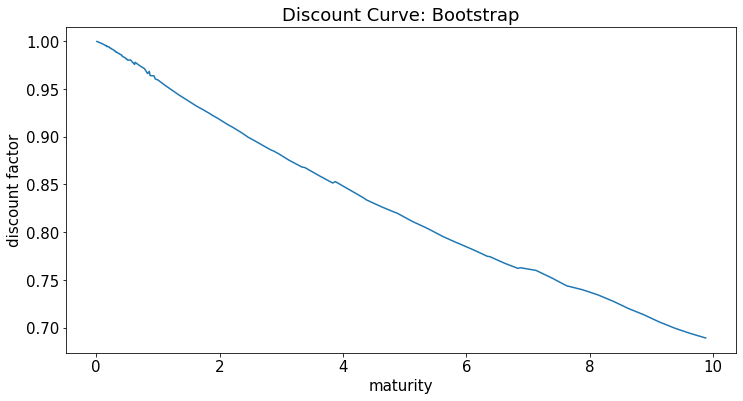

In [13]:
MODEL = bootstrap

RESTRICT_YLD = True
RESTRICT_TIPS = True

RESTRICT_DTS_MATURING = True
RESTRICT_REDUNDANT = True

data = filter_treasuries(rawdata, t_date=t_current, filter_yld = RESTRICT_YLD, filter_tips = RESTRICT_TIPS, drop_duplicate_maturities=RESTRICT_REDUNDANT)
CF = filter_treasury_cashflows(calc_cashflows(data),filter_maturity_dates=RESTRICT_DTS_MATURING)

prices = metrics['price'][CF.index]
params_boot = estimate_rate_curve(MODEL,CF,t_current,prices)

label = 'single maturity per date, no non-maturity dates'
CFset[label] = CF

plt.plot(params_boot[0],params_boot[1])
plt.xlabel('maturity')
plt.ylabel('discount factor')
plt.title('Discount Curve: Bootstrap')
plt.show()

## OLS Estimation

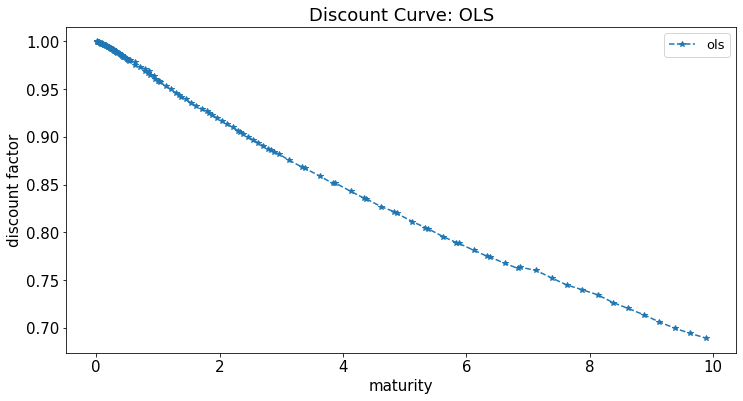

In [14]:
MODEL = bootstrap

RESTRICT_YLD = True
RESTRICT_TIPS = True

RESTRICT_DTS_MATURING = True
RESTRICT_REDUNDANT = False

data = filter_treasuries(rawdata, t_date=t_current, filter_yld = RESTRICT_YLD, filter_tips = RESTRICT_TIPS, drop_duplicate_maturities=RESTRICT_REDUNDANT)
CF = filter_treasury_cashflows(calc_cashflows(data),filter_maturity_dates=RESTRICT_DTS_MATURING)

prices = metrics['price'][CF.index]
params_OLS = estimate_rate_curve(MODEL,CF,t_current,prices)

label = 'no non-maturity dates'
CFset[label] = CF

disc_ols = pd.DataFrame({'maturity':params_OLS[0], 'ols': params_OLS[1]}).set_index('maturity')
disc_ols.plot(marker='*',linestyle='--',ylabel='discount factor',title='Discount Curve: OLS')
plt.show()

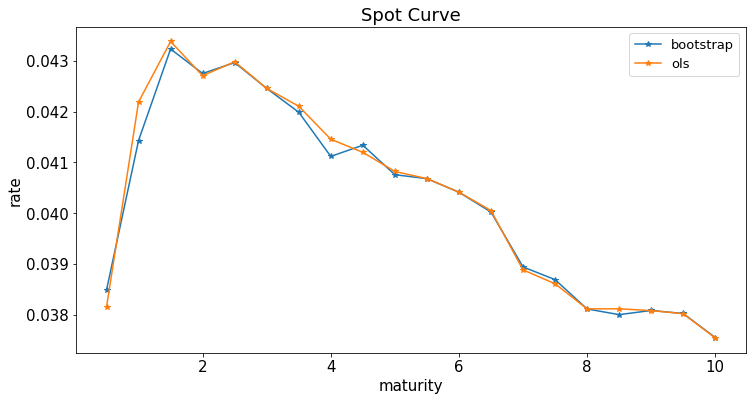

In [15]:
inc = .5

maturity_grid = np.arange(inc,disc_ols.index.to_series().max()+.5,inc)
curves_ols = pd.DataFrame(index = maturity_grid)
curves_ols['bootstrap'] = bootstrap(params_boot,maturity_grid)
curves_ols['ols'] = bootstrap(params_OLS,maturity_grid)

ax = curves_ols.plot(linestyle='-',marker='*',ylabel='rate',xlabel='maturity',title='Spot Curve')
plt.show()

In [16]:
RESTRICT_YLD = True
RESTRICT_TIPS = True

RESTRICT_DTS_MATURING = False
RESTRICT_REDUNDANT = False

data = filter_treasuries(rawdata, t_date=t_current, filter_yld = RESTRICT_YLD, filter_tips = RESTRICT_TIPS, drop_duplicate_maturities=RESTRICT_REDUNDANT)

CF = filter_treasury_cashflows(calc_cashflows(data),filter_maturity_dates=RESTRICT_DTS_MATURING)
CFset['all dates'] = CF

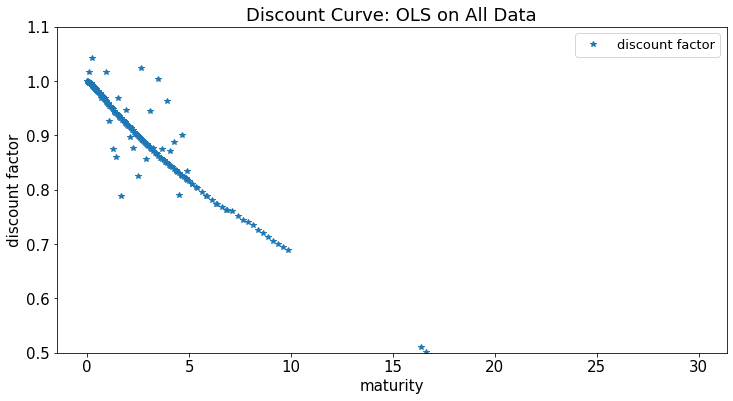

In [17]:
prices = metrics['price'][CF.index]
params_OLS_bad = estimate_rate_curve(MODEL,CF,t_current,prices)

disc_ols_bad = pd.DataFrame({'maturity':params_OLS_bad[0], 'discount factor': params_OLS_bad[1]}).set_index('maturity')
disc_ols_bad.plot(marker='*',linestyle='',ylim=(.5,1.1),ylabel='discount factor',title='Discount Curve: OLS on All Data')
plt.show()

# Problem 3: Nelson-Siegel Curve
## *Optional*

No need to submit this problem, but if we discuss it, then you are expected to know it.

Use the Nelson-Siegel curve to model the discount rates. 

Fit them via minimizing the sum of squared errors for the prices imputed by the model versus the quoted prices. 

You might try estimating via non-linear least squares.

Estimate the model three times, using $\textbf{C}$, $\tilde{\textbf{C}}$, $\hat{\textbf{C}}$.

Plot the estimated discount factors, $\textbf{z}_{\text{ns}}$ against time-to-maturity.

Also plot the associated continuously-compounded discount rates.

# <span style="color:red">Solution 3</span>

In [18]:
prices = metrics['price'][CF.index]

x0 = np.ones((1,4))/10
params_NS = estimate_rate_curve(nelson_siegel,CF,t_current,prices,x0)

x0 = np.concatenate((params_NS,(2,2)))
params_NSE = estimate_rate_curve(nelson_siegel_extended,CF,t_current,prices,x0=x0)

tab_params_ns = pd.DataFrame(data = params_NS, index=['theta 0', 'theta 1', 'theta 2', 'lambda_1'],columns=['Nelson-Siegel']).T
tab_params_ns.loc[:,['theta_3', 'lambda_2']] = None
tab_params_ns.loc['Nelson-Siegel Extended',:] = params_NSE
tab_params_ns

,theta 0,theta 1,theta 2,lambda_1,theta_3,lambda_2
Nelson-Siegel,0.039081,-0.019082,0.037493,0.458785,None,None
Nelson-Siegel Extended,-2.702307,2.750199,0.358408,15.797674,6.310813,43.112542


### Use these fitted paramaters to calculate the Spot Curve

Note that the parameterized functional form allows us to model the curve 
* for any maturity.
* in a smooth way that avoids recommending extreme long-short positions

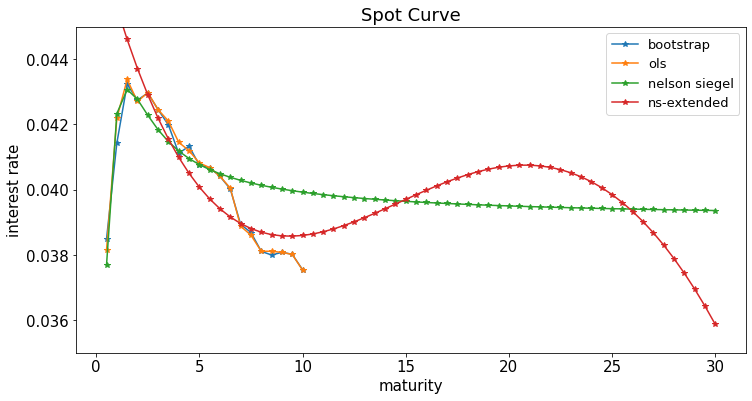

In [19]:
inc = .5

maturity_list = get_maturity_delta(list(CFset.values())[-1].columns,t_current=t_current)
maturity_grid = np.arange(inc,maturity_list.max()+.5,inc)
curves = pd.DataFrame(index = maturity_grid)
curves['nelson siegel'] = nelson_siegel(params_NS,maturity_grid)
curves['ns-extended']= nelson_siegel_extended(params_NSE,maturity_grid)

ax = curves_ols.plot(linestyle='-',marker='*')
curves.plot(ax=ax, linestyle='-',marker='*', ylim=(0,1.1*curves.max().max()*1.1))

series_plotted = list(curves_ols.columns) + list(curves.columns)
plt.legend(series_plotted)
plt.ylim(.035,.045)
plt.xlabel('maturity')
plt.ylabel('interest rate')
plt.title('Spot Curve')
plt.show()

### Convert the spot curve to the discount curve

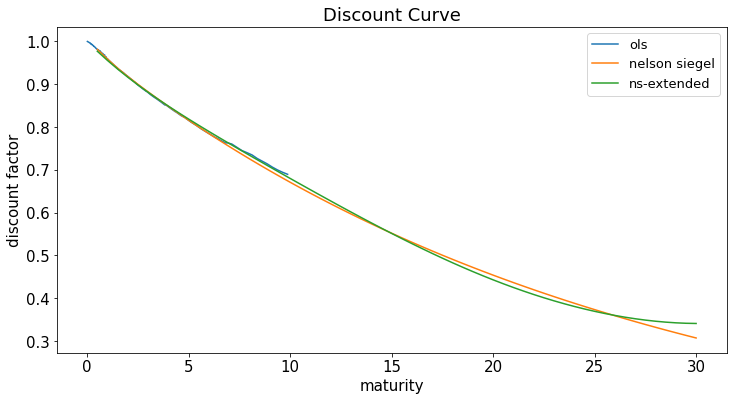

In [20]:
ax = disc_ols.plot()

zero_curve = intrate_to_discount(curves.loc[:,'nelson siegel'], maturity_grid, n_compound=None).to_frame()
zero_curve['ns-extended'] = intrate_to_discount(curves.loc[:,'ns-extended'], maturity_grid, n_compound=None).to_frame()
zero_curve.plot(ax=ax, title='Discount Curve', xlabel='maturity',ylabel='discount factor')

plt.show()

# Summary

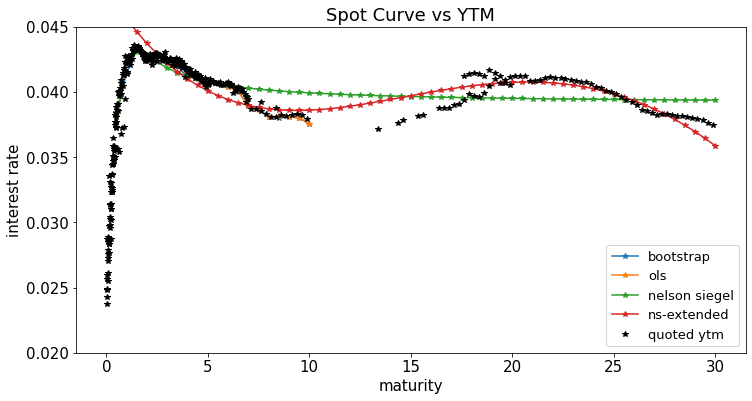

In [21]:
ax = curves_ols.plot(linestyle='-',marker='*')
curves.plot(ax=ax, linestyle='-',marker='*', ylim=(0,curves.max().max()*1.1))
table.set_index('maturity')['ytm'].plot(ax=ax, linestyle='',marker='*', color='k')

series_plotted = list(curves_ols.columns) + list(curves.columns) + ['quoted ytm']
plt.legend(series_plotted)
plt.xlabel('maturity')
plt.ylabel('interest rate')
plt.ylim(.02,.045)
plt.title('Spot Curve vs YTM')
plt.show()